In [1]:
import numpy as np
import matplotlib.pyplot as plt


In [2]:
class TwoLevel:
    def __init__(self, config):
        self.config = config
        
        self.t0 = config["t0"]
        self.tf = config["tf"]
        self.Nt = config["Nt"]
        self.t, self.dt  = np.linspace(self.t0,self.tf,self.Nt,retstep=True)
        
        self.Delta = config["Delta"]
        self.Omega = config["Omega"]
        self.InitState = config["InitState"]
        
        self.GroundState = np.array([0,1])
        self.ExcitedState = np.array([1,0])
        
        self.HamSetup()
    
    def HamSetup(self):
        #RWA Hamiltonian in the Rotating Frame
        proj_e = np.array([[1,0],[0,0]])
        sigma_p = np.array([[0,1],[0,0]])
        sigma_m = np.array([[0,0],[1,0]])
        sigma_z = np.array([[1,0],[0,-1]])
#         self.HRWA = -self.Delta*proj_e + self.Omega/2*(sigma_p + sigma_m)
        self.HRWA = -self.Delta/2*sigma_z + self.Omega*(sigma_p + sigma_m)
    
    def Evolution(self):
        self.WFArray = np.zeros((self.Nt,2),dtype='complex64')
        Psi = self.InitState
        self.WFArray[0] = Psi
        for i in range(1,self.Nt):
            PsiN = self.Step(Psi)
            Psi = PsiN
            self.WFArray[i] = Psi
    
    def Step(self,Psi):
        M = np.identity(2)-0.5*1j*self.HRWA*self.dt
        Mp = np.identity(2)+0.5*1j*self.HRWA*self.dt
        self.U = np.linalg.inv(Mp).dot(M)
        return self.U.dot(Psi)
    

class MCWF:
    def __init__(self, config):
        self.config = config
        
        self.t0 = config["t0"]
        self.tf = config["tf"]
        self.Nt = config["Nt"]
        self.t, self.dt  = np.linspace(self.t0,self.tf,self.Nt,retstep=True)
        
        self.Delta = config["Delta"]
        self.Omega = config["Omega"]
        self.Gamma = config["Gamma"]
        self.InitState = config["InitState"]
        
        self.GroundState = np.array([0,1])
        self.ExcitedState = np.array([1,0])
        
        self.NPaths = config["NPaths"]
        
        self.HamSetup()
    
    def HamSetup(self):
        #RWA Hamiltonian in the Rotating Frame
        proj_e = np.array([[1,0],[0,0]])
        sigma_p = np.array([[0,1],[0,0]])
        sigma_m = np.array([[0,0],[1,0]])
        sigma_z = np.array([[1,0],[0,-1]])
        self.HRWA = -self.Delta/2*sigma_z + self.Omega*(sigma_p + sigma_m)
    
    def Evolution(self):
        p_ground = np.zeros((self.NPaths, self.Nt))
        p_excited = np.zeros((self.NPaths, self.Nt))
        
        for j in range(self.NPaths):
            self.WFArray = np.zeros((self.Nt,2),dtype='complex64')
            Psi = self.InitState
            self.WFArray[0] = Psi
            for i in range(1,self.Nt):
                dp = self.Gamma*np.abs(Psi[0])**2*self.dt
                rand = np.random.rand()
                if rand < dp:
                    Psi = self.GroundState
                else:
                    mu = (1-dp)**(-1/2)
                    PsiN = self.Step(Psi, mu)
                    PsiN = PsiN/(np.sqrt(PsiN.dot(np.conj(PsiN))))
                    Psi = PsiN
                self.WFArray[i] = Psi
            prob = np.abs(self.WFArray)**2
            
            p_ground[j] = prob[:,1]
            p_excited[j] = prob[:,0]
        
        self.ProbGround = np.mean(p_ground, 0)
        self.ErrorGround = np.std(p_ground, 0)/np.sqrt(self.NPaths)
        self.ProbExcited = np.mean(p_excited, 0)
        self.ErrorExcited = np.std(p_excited, 0)/np.sqrt(self.NPaths)
        
    def Step(self,Psi,mu=1.0):
        M = np.identity(2)-0.5*1j*self.HRWA*self.dt
        Mp = np.identity(2)+0.5*1j*self.HRWA*self.dt
        self.U = np.linalg.inv(Mp).dot(M)
        return mu*self.U.dot(Psi)


In [3]:
config1 = {
         "t0": 0.0,
         "tf": 4.0,
         "Nt": 1000,
         "Delta": 0,
         "Omega": 3.0,
         "InitState": np.array([0,1])
        }
config2 = {
         "t0": 0.0,
         "tf": 4.0,
         "Nt": 1000,
         "Delta": 5,
         "Omega": 3.0,
         "InitState": np.array([0,1])
        }
config3 = {
         "t0": 0.0,
         "tf": 4.0,
         "Nt": 1000,
         "Delta": 10,
         "Omega": 3.0,
         "InitState": np.array([0,1])
        }

configMCWF = {
         "t0": 0.0,
         "tf": 4.0,
         "Nt": 1000,
         "Delta": 0,
         "Omega": 3.0,
         "Gamma": 1.0,
         "InitState": np.array([0,1]),
         "NPaths": 500
        }

In [4]:
TL1 = TwoLevel(config1)
TL1.Evolution()

TL2 = TwoLevel(config2)
TL2.Evolution()

TL3 = TwoLevel(config3)
TL3.Evolution()

MC = MCWF(configMCWF)
MC.Evolution()

In [5]:
WF1 = np.abs(TL1.WFArray)**2
excited1 = WF1[:,0]
ground1 = WF1[:,1]

WF2 = np.abs(TL2.WFArray)**2
excited2 = WF2[:,0]
ground2 = WF2[:,1]

WF3 = np.abs(TL3.WFArray)**2
excited3 = WF3[:,0]
ground3 = WF3[:,1]

WFMc = [MC.ProbExcited,MC.ProbGround]
ErrorMc = [MC.ErrorExcited,MC.ErrorGround]
excitedMc = WFMc[0]
error_excitedMc = ErrorMc[0]
groundMc = WFMc[1]
error_groundMc = ErrorMc[1]


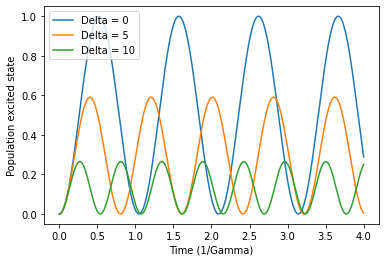

In [6]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(TL1.t,excited1,label = "Delta = 0")
ax.plot(TL2.t,excited2,label = "Delta = 5")
ax.plot(TL3.t,excited3,label = "Delta = 10")
ax.set_ylabel("Population excited state")
ax.set_xlabel("Time (1/Gamma)")

# ax.set_ylim(0,1.0)
plt.legend(loc="upper left")

# plt.savefig("fig/TwoLevel_vs_MCWF.pdf",bbox_inches='tight')

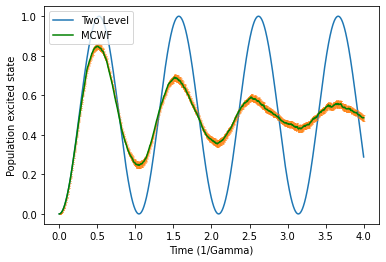

In [7]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(TL1.t,excited1,label = "Two Level")
ax.errorbar(MC.t,excitedMc,yerr=error_excitedMc,capsize=0.5,elinewidth=0.5,markeredgewidth=0.5,linestyle='None')
ax.plot(MC.t,excitedMc,'g',label = "MCWF")
ax.set_ylabel("Population excited state")
ax.set_xlabel("Time (1/Gamma)")

# ax.set_ylim(0,1.0)
plt.legend(loc="upper left")

# plt.savefig("fig/TwoLevel_vs_MCWF.pdf",bbox_inches='tight')